In [1]:
import numpy as np
import scipy
import scipy.ndimage as nd
import scipy.cluster.vq as vq
from PIL import Image
import math
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

In [2]:
# read in 3 images as numpy arrays
img1 = Image.open('img01.jpg')
img1 = np.asarray(img1, dtype=np.uint8)

img2 = Image.open('img02.jpg')
img2 = np.asarray(img2, dtype=np.uint8)

img3 = Image.open('img03.jpg')
img3 = np.asarray(img3, dtype=np.uint8)

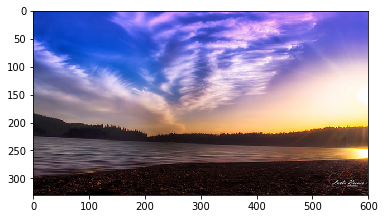

In [3]:
plt.imshow(img3)
plt.show()

In [4]:
# Helper function which declares an array that will keep track of the probabilities of an pixel belonging to 
# a particular cluster.
def gen_temp_arrays(arr, num):
    arr1 = np.zeros((len(arr), len(arr[0]), num))
    return arr1

In [5]:
def find_wij(pixel, means, probs, cur_mean, num_means, temp_probs, x, y):
    '''
    Computes the W_ij term (essentially the probabilities for a pixel to belong to a particular blob).
    @param pixel: The current pixel for which we are computing the probabilities (the X_i).
    @param means: The current array of means for the j clusters.
    @param probs: The current array of proportions for the j clusters.
    @param cur_mean: The current mean index we are computing for (The u_j).
    @param num_means: The total number of means, which is equivilant to the total number of clusters.
    '''
    # Cast to float to get faster run-times.
    mean_f = means.astype(float)
    pixel_f = pixel.astype(float)    
        
    # For each of the clusters, we compute the inner value of the exponential.
    val = [-0.5 * np.dot((pixel_f - mean_f[i]), (pixel_f - mean_f[i])) for i in range(num_means)]
    
    # Then shift each of the values by subtracting from the largest element in the list.
    # This corrects for potential underflow or overflow issues.
    val -= max(val)
    
    # Compute the numerator which is the exponential of the gaussian expression with the cur_mean multiplied by 
    # the probability of the current blob being expressed by the dataset.
    numer = np.exp(val[cur_mean])*probs[cur_mean]
    
    # Now take the sum of the exponentials of the gaussian expression with each of the cluster means multiplied by
    # the probability of the "j_th" blob being expressed by the dataset.    
    denom = np.dot(np.exp(val), probs)
    
    # Return the divison of each of these two numbers, which roughly expresses the probability of this pixel belonging to
    # the blob.
    wij = numer / denom
    temp_probs[x][y][cur_mean] = wij
    
    return wij

In [6]:
def shift_and_normalize(image):
    '''
    After talking with the TAs, we came to the conclusion that only 
    shifting the mean to be zero and having unit standard deviation.
    @param image: The image to perform the affine transformation on.
    '''
    
    # First shift the image such that it has zero mean
    mean = np.mean(image, axis=(0,1))
    image = (image - np.mean(image, axis=(0, 1)))
    
    # Now scale by dividing by the standard deviation.
    temp_image = np.reshape(image, (len(image) * len(image[0]), 3))
    
    # Compute the Standard deviation for the RGB values.
    std_dev = np.std(temp_image, axis=0)
    result = image / std_dev
    
    # Return the normalized image with the old std_dev and the means.
    return mean, std_dev, image

In [7]:
def em_step(num_means, image):
    '''
    This function performs the iterative 'E' and 'M' step for the mixture of gaussians.
    @param num_means: The number of segments(clusters) to use.
    @param image: The image where the clustering will take place, represented as an numpy array.
    '''
    # Define a tolerance to which we know when to stop.
    eps = .01
    temp_array = np.reshape(img1, (len(img1) * len(img1[0]), 3))

    # Generate the init_means and init_pi(s)
#     kmeans = KMeans(n_clusters=num_means, max_iter=1).fit(temp_array)
#     init_mean = kmeans.cluster_centers_
#     init_pi = np.array([len(np.where(kmeans.labels_== x)[0]) for x in np.unique(kmeans.labels_)]).astype('float32')/len(kmeans.labels_)
    init_pi = np.full((num_means,), 1./num_means)
    init_mean = np.zeros((num_means, 3))
    num_pixels = len(image) * len(image[0])
    # Set the initial mean vector to be randomly sampled pixels from the image.\n",
    for m in range(num_means):
        rand_row = np.random.randint(0, len(image))
        rand_col = np.random.randint(0, len(image[0]))
        init_mean[m] = image[rand_row][rand_col]
        
    # Construct a vector that will hold the probabilities that a particular pixel belongs to a specific cluster.\n",
    temp_probs = gen_temp_arrays(image, num_means)
        
    # Construct a vector that will hold the probabilities that a particular pixel belongs to a specific cluster.
    temp_probs = gen_temp_arrays(image, num_means)
    #old_mean, old_std_dev, new_image = shift_and_normalize(image)
    new_image = image
    num_pixels = len(image) * len(image[0])
    print(init_mean.shape)
    old_mean = np.copy(init_mean)
    count = 0
    
    # Iterate over each cluster. For each cluster compute the probability that a pixel belongs to a cluster.
    # Use these probabilities to calculate a new approximation for both the mean and proportion of the cluster.
    # We will set a max_iteration of 100, but if it reaches a local max it will converge.
    for i in range(3):
        for curMeanIndex in range(len(init_mean)):
            numerator = np.zeros((3, ))
            denominator = 0
            for i in range(len(image)):
                for j in range(len(image[0])):
                    # Compute the probability that this pixel is a member of this cluster.
                    temp_pixel = new_image[i][j]
                    wij = find_wij(temp_pixel, init_mean, init_pi, curMeanIndex, num_means, temp_probs, i, j)
                    
                    # Use this probability to compute the updated means and proportions for this dataset.
                    numerator += temp_pixel * wij
                    denominator += wij


            # Update the value of the mean for the particular 'blob'.
            newMean = (numerator / denominator)
            newPop = (denominator / num_pixels)
                        
            
            # Otherwise update the estimate of the mean and proportion of the particular cluster.
            init_mean[curMeanIndex] = newMean
            init_pi[curMeanIndex] = newPop
        
        
        diff = sum([euclidean(init_mean[i], old_mean[i]) for i in range(len(init_mean))])
        print("Done with one iteration.")  
        print(diff)
        if (diff < eps and count > 2):
            return init_mean, init_pi, temp_probs
        count += 1
        
        old_mean = np.copy(init_mean)
            
        
        
        
    return (init_mean, init_pi, temp_probs)        


First, we will segment the first image into 10, 20, and 50 segments.

In [10]:
img1_mean_10, img1_pi_10, img1_temp_probs_10 = em_step(10, img1)
# img2_mean_10, img2_pi_10, img2_temp_probs_10 = em_step(10, img2)
# img3_mean_10, img3_pi_10, img3_temp_probs_10 = em_step(10, img3)

(10, 3)
Done with one iteration.
172.33568251564253
Done with one iteration.
101.18665825180835
Done with one iteration.
67.62515661448417


In [ ]:
img1_mean_20, img1_pi_20, img1_temp_probs_20 = em_step(20, img1)
img2_mean_20, img2_pi_20, img2_temp_probs_20 = em_step(20, img2)
list_of_sunset_means = list()
list_of_sunset_means.append(em_step(20, img3))

In [ ]:
img1_mean_50, img1_pi_50, img1_temp_probs_50 = em_step(20, img1)
img2_mean_50, img2_pi_50, img2_temp_probs_50 = em_step(20, img2)
img3_mean_50, img3_pi_50, img3_temp_probs_50 = em_step(20, img3)

In [11]:
img1_mean = img1_mean_10.astype(np.uint8)

In [12]:
new_img = np.zeros((len(img1), len(img1[0]), 3))
for i in range(len(img1)):
    for j in range(len(img1[0])):
        val_max = np.argmax(img1_temp_probs_10[i][j])
        new_img[i][j] = img1_mean_10[val_max]


In [13]:
new_img = new_img.astype(np.uint8)

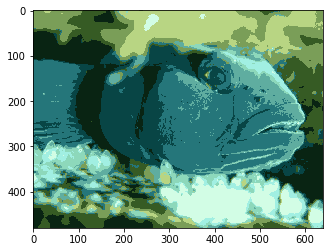

In [14]:
plt.imshow(new_img)
plt.show()

In [ ]:
print(img1_mean)